## Test how number of iterations and refractive index of sample effect deconvoluton of a high SNR bead image

In this notebook I test how the number of iterations and the value used for refractive index of the sample effect deconvolution of a high SNR widefield bead image.  The sample is a bead of known radius 2.5 um from the EPFL BIG lab and can be found [here](http://bigwww.epfl.ch/deconvolution/bead/).  I want to determine how many iterations Richardson Lucy will continue to 'improve' for.  I also want to investigate if the PSF used changes the optimal number of iterations (for example will artifacts appear earlier if a slightly mismatched PSF is used.)

Disclaimer:  This notebook is based on code from my own personal repository where I store useful code snippets and examples.  I've organized the repository into namespaces and modules, some of which I find very useful for prototyping, however the code-base has not undergone extensive validation so there could be bugs.

Assumptions:  I assume the bead is apr. 20 microns from the coverslip based on the dimensions of the original image and the spacings.  I also assume the main cause of SA is the mismatch between the Oil and the substance that the bead is embedded in (assume that the coverslip and oil are matched.).  I am not a microscopist so happy to learn of better assumptions. 

Potential Improvements:  THe PSFs are generated with a Gibson Lanni implementation.  Perhaps even better results could be obtained with a vectorial model, and accounting for additional mismatch because of the coverslip. 

Take home point:  After generating deconvolutions using several sample RIs and iterations of 80, 400 and 2000 the most 'accurate' result (with respect to the known spherical shape of the bead) was obtained with an RI of 1.49 and using 2000 iterations.  Richardson Lucy deconvolution of a simple object continues to improve for a couple thousand iterations if the correct PSF is used.  More testing would be needed to determine if this conclusion holds for more complicated object shapes (and of course several thousand iterations could be problematic with lower SNR images).

## Load the test image

Load the test image and crop the image a bit as to speed up testing.  We also reverse the z axis of the stack so that it is consistent with positive 'depth' being below the coverslip.

size of bead image:  (256, 256, 256)
size of cropped bead image:  (50, 256, 256)


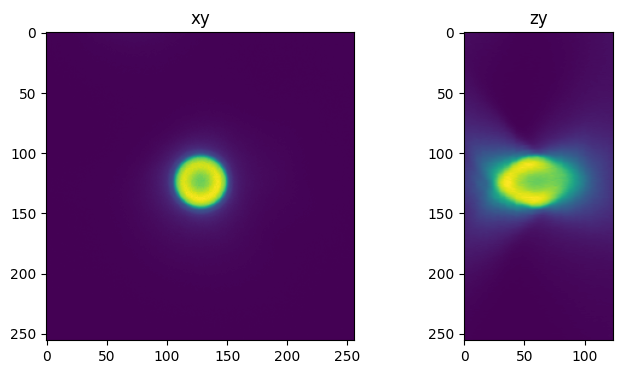

In [3]:
from skimage.io import imread
import numpy as np
from tnia.plotting.projections import show_xy_zy_slice

path_=r"D:\images\tnia-python-images\deconvolution\bead"

bead=imread(path_+"/Bead.tif")
print('size of bead image: ',bead.shape)
z_start=75
z_end=125
z_to_view=(z_end-z_start)//2

# define the region of interest to speed up the processing
roi=np.s_[z_start:z_end, :, :]
bead=bead[roi]
bead=bead[::-1,:,:]
print('size of cropped bead image: ',bead.shape)
xy_spacing = 0.0645
z_spacing=.16

ratio = z_spacing/xy_spacing

fig=show_xy_zy_slice(bead,128,128,z_to_view, sz=ratio, figsize=(8,4))

## Generate PSFs at different specimen refractive indexes.

Here we generate multiple PSFs.  The meta data does not include the refractive index of the medium the bead is embedded in.  It is likely close to, but not exactly the refractive index of the lens immersion media, thus we try different values between 1.4 and 1.52

sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected


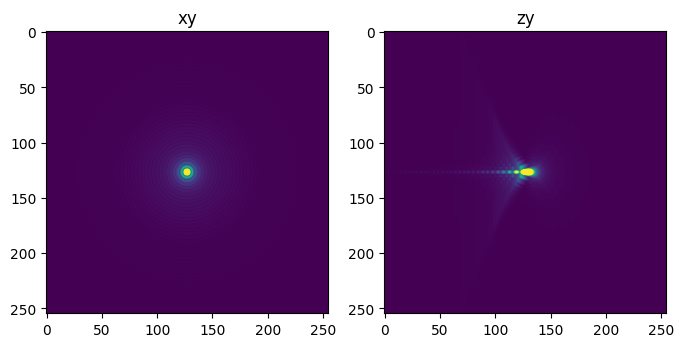

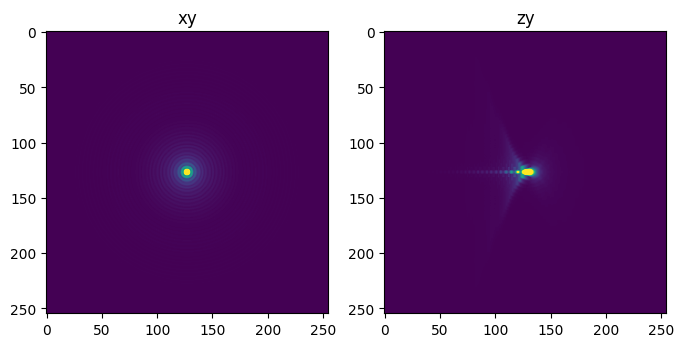

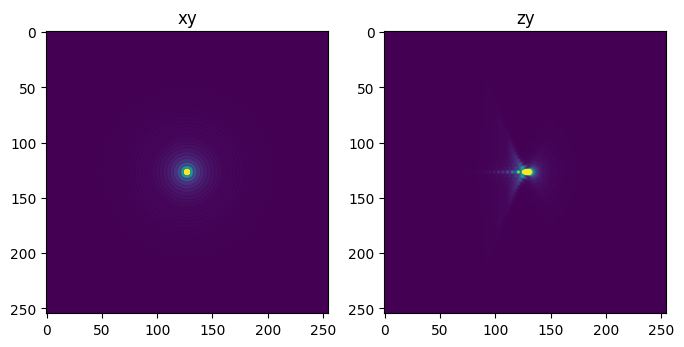

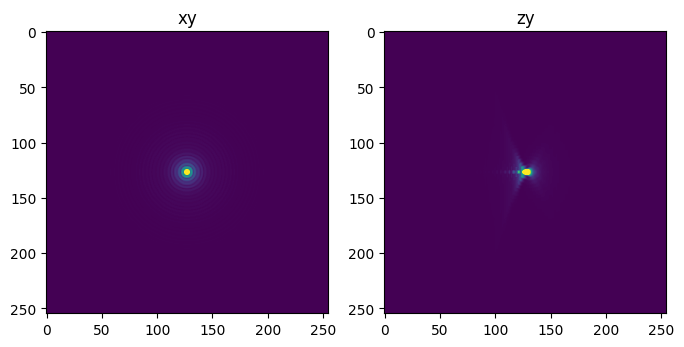

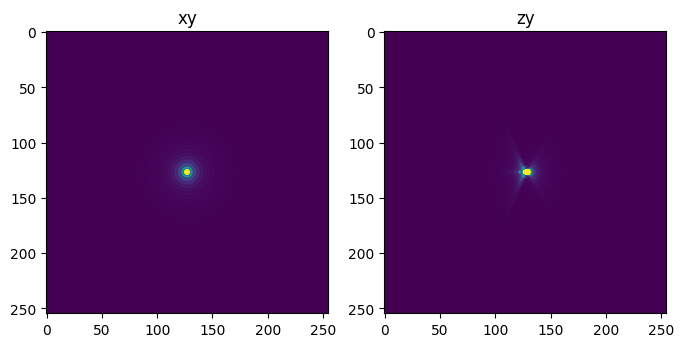

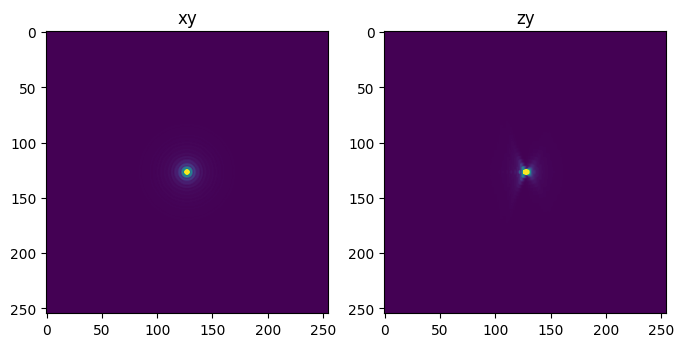

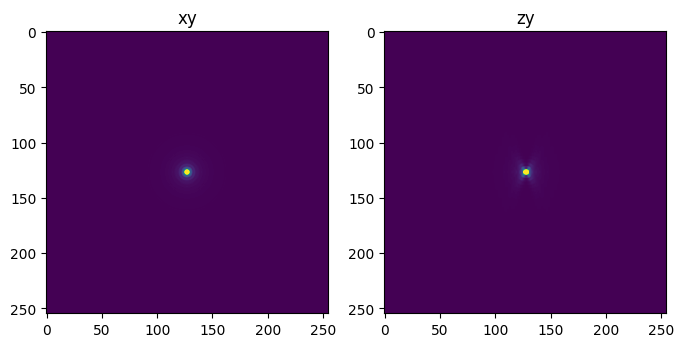

In [5]:
from tnia.nd.ndutil import centercrop
from tnia.deconvolution.psfs import gibson_lanni_3D
from tnia.plotting.projections import show_xy_zy_max
from tnia.deconvolution.psfs import recenter_psf_axial
from skimage.io import imsave

ni=1.518
ns=1.48
ns_to_test=[1.42,1.44,1.46,1.48,1.49,1.50,1.518]
NA=1.4
w=0.530

xy_spacing = 0.0645
z_spacing=.16

xy_psf_dim=255
z_compute_psf_dim=599
z_crop_psf_dim=255

#depth to compute PSF at
d=128*z_spacing

psfs=[]
for ns in ns_to_test:

    psf  = gibson_lanni_3D(NA, ni, ns, xy_spacing, z_spacing, xy_psf_dim, z_compute_psf_dim, d, w)
    psf = psf.astype('float32')

    #fig=show_xy_zy_max(psf, vmax=psf.max())
    psf=recenter_psf_axial(psf, 255)
    #psf,labels=recenter_psf_axial(psf, 255, return_labels=True)
    #fig=show_xy_zy_max(labels)
    fig=show_xy_zy_max(psf, vmax=psf.max()/4, figsize=(8,4))
    psfs.append(psf)
    
#imsave(path_+"/PSF-SA.tif", psf)

## Run deconvolution multiple times with different PSFs

Now we run the deconvolution with each of the different PSFs and also different iteration numbers

In [9]:
from clij2fft.richardson_lucy import richardson_lucy_nc
from skimage.io import imsave

regularization_factor=0.00005
iterations_to_try=[80,400,2000]
decons=[]
for iterations in iterations_to_try:
    decons_temp=[]
    for psf, ns in zip(psfs, ns_to_test):
        im_decon = richardson_lucy_nc(bead, psf, iterations, regularization_factor)
        decons_temp.append(im_decon)
        fname=path_+"/Decon-RL-ns-"+str(ns)+"-iters-"+str(iterations)+"-reg"+str(regularization_factor)+".tif"
        imsave(fname, im_decon)
        #fig=show_xy_zy_slice(im_decon,128,128,25, sz=ratio)
        #fig.suptitle('decon ns='+str(ns))
    decons.append(decons_temp)

get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib
get lib


1
2
3


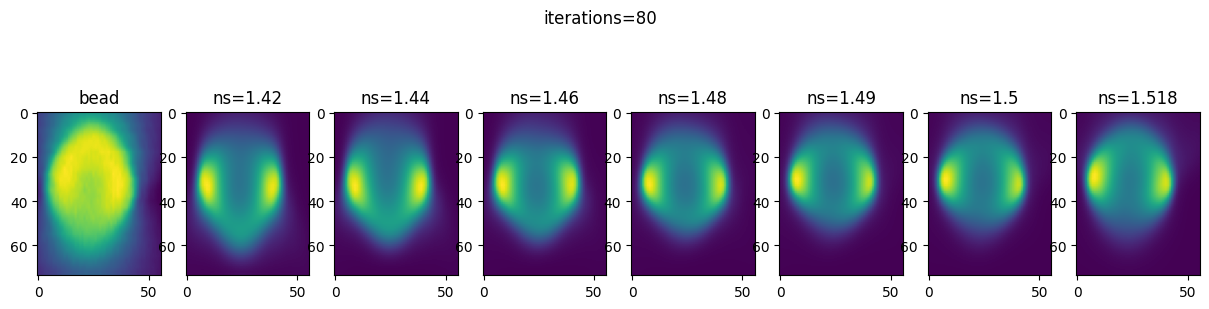

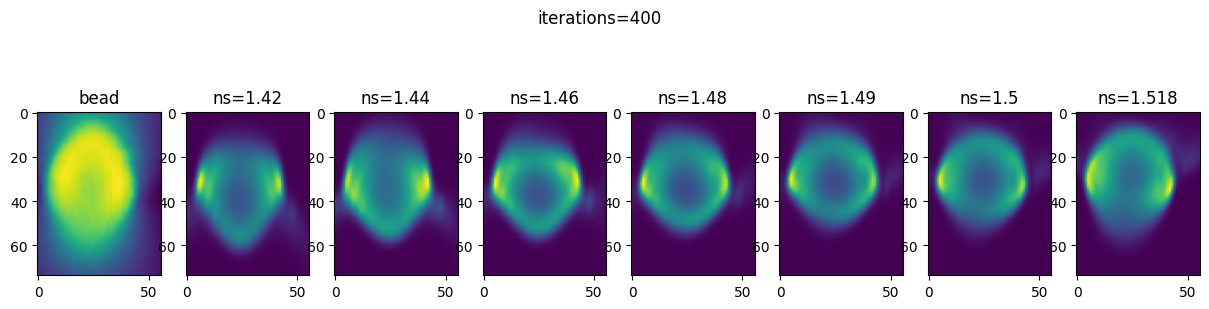

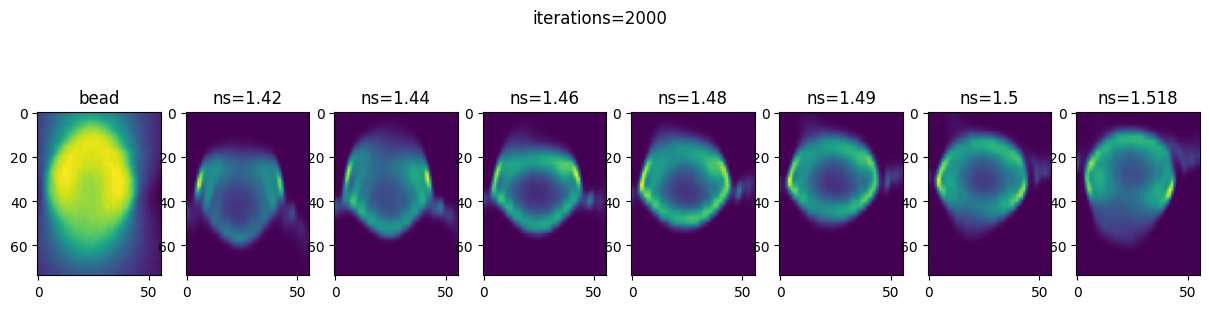

In [10]:

from tnia.plotting.plt_helper import imshow_multi2d
from skimage.transform import resize
decons_=[]
titles = []
ind = np.s_[10:40, 100:156, 120]

bead_=bead[ind]
bead_ = resize(bead_, (int(bead_.shape[0]*ratio), bead_.shape[1]), anti_aliasing=True)

i=0
for iterations in iterations_to_try:
    decons_=[]
    decons_.append(bead_)
    titles.append('bead')
    for decon, ns in zip(decons[i], ns_to_test):
        #fig=show_xy_zy_slice(decon,128,128,25, sz=ratio)
        #fig.suptitle('decon ns='+str(ns))
        temp = decon[ind]
        temp = resize(temp, (int(temp.shape[0]*ratio), temp.shape[1]), anti_aliasing=True)
        decons_.append(temp)
        titles.append('ns='+str(ns))

    fig = imshow_multi2d(decons_, titles, 1, 8, 15, 3.8)
    fig.suptitle('iterations='+str(iterations))
    i=i+1
    print(i)

In [73]:
import napari

viewer = napari.Viewer()

viewer.add_image(bead, name='bead', scale=[z_spacing, xy_spacing, xy_spacing])
viewer.add_image(decons[2][0], name='decon 80', scale=[z_spacing, xy_spacing, xy_spacing])
viewer.add_image(decons[2][2], name='decon 400', scale=[z_spacing, xy_spacing, xy_spacing])
viewer.add_image(decons[2][4], name='decon 2000', scale=[z_spacing, xy_spacing, xy_spacing])


<Image layer 'decon 2000' at 0x1ab39c83e50>

## Threshold and measure axial dimension

Below we apply Otsu threshold to each deconvolution, generate an Otsu threshold, then object labels (there should only bne 1 object barring noise amplifications or an artifact).  

We can then calculate the siza of the bounding bnox in the axial direction.  In this case there is very little spherical aberration so values between 1.48 and 1.52 give a good final measurement.

1
2
3


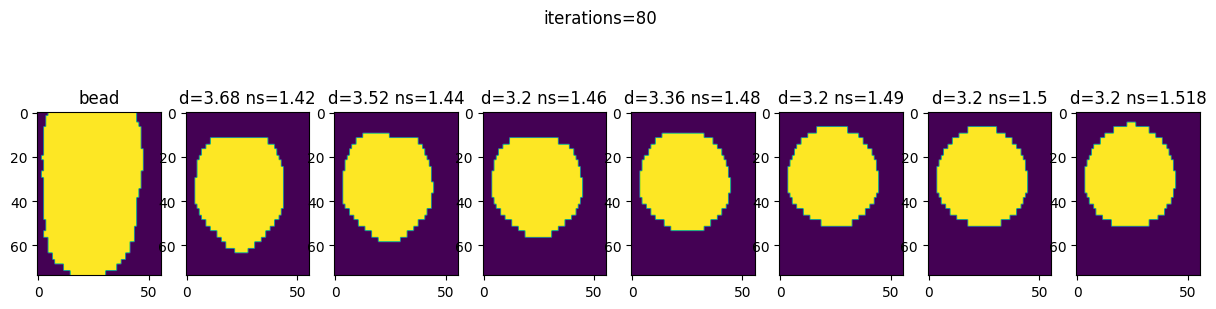

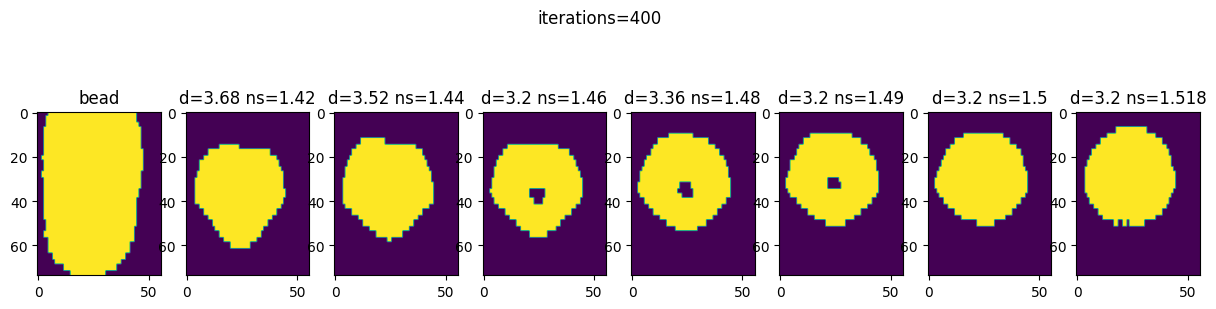

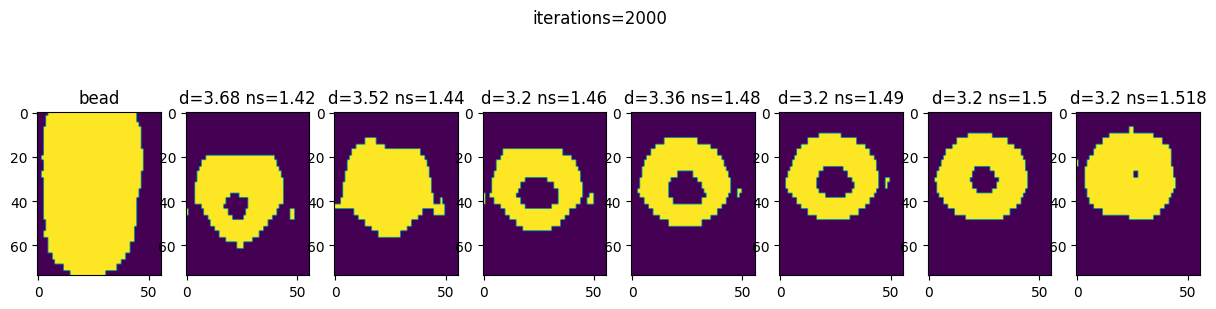

In [15]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.measure import regionprops
decons_=[]
titles = []
ind = np.s_[10:40, 100:156, 120]

bead_th=bead>threshold_otsu(bead)
bead_=bead_th[ind]
bead_ = resize(bead_, (int(bead_.shape[0]*ratio), bead_.shape[1]))

i=0
for iterations in iterations_to_try:
    decons_=[]
    decons_.append(bead_)
    titles.append('bead')
    for decon, ns in zip(decons[i], ns_to_test):
        #fig=show_xy_zy_slice(decon,128,128,25, sz=ratio)
        #fig.suptitle('decon ns='+str(ns))
        decon_th=decon>threshold_otsu(decon)
        decon_labeled=label(decon_th)

        decon_objects=regionprops(decon_labeled)
        o = decon_objects[0]
        measurement=(o.bbox[3]-o.bbox[0])*z_spacing
        temp = decon_th[ind]
        temp = resize(temp, (int(temp.shape[0]*ratio), temp.shape[1]))
        decons_.append(temp)
        titles.append('d='+str(measurement)+' ns='+str(ns))

    fig = imshow_multi2d(decons_, titles, 1, 8, 15, 3.8)
    fig.suptitle('iterations='+str(iterations))
    i=i+1
    print(i)

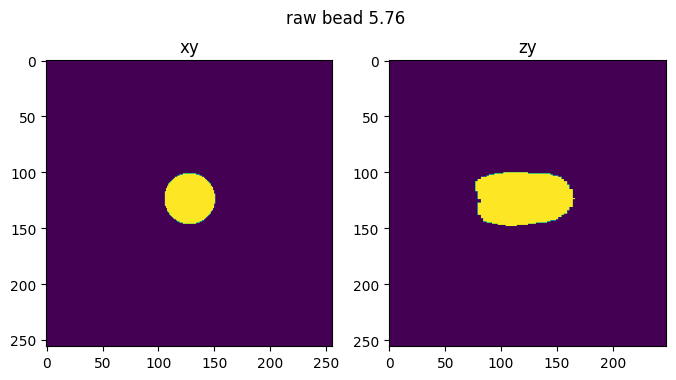

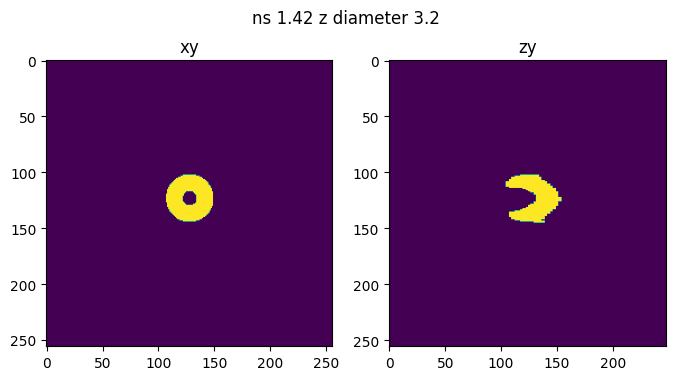

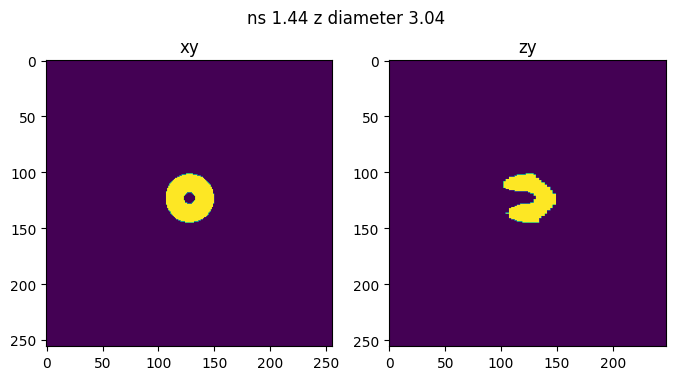

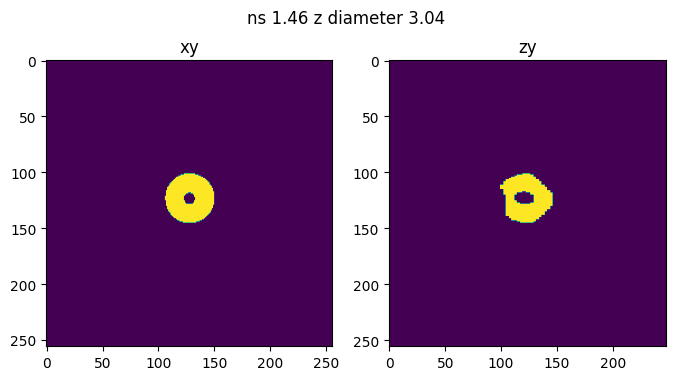

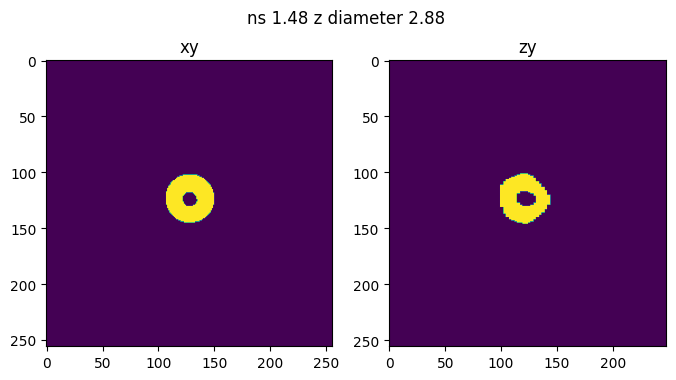

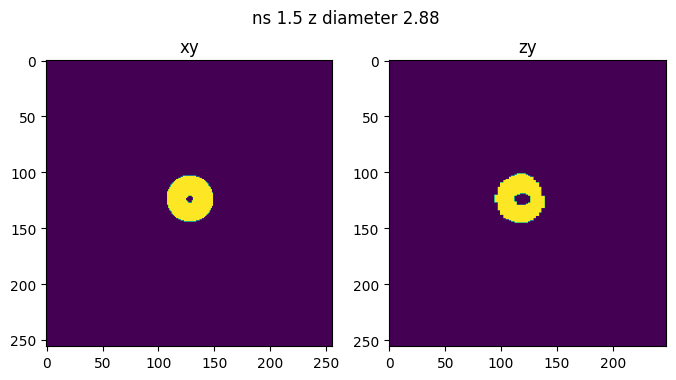

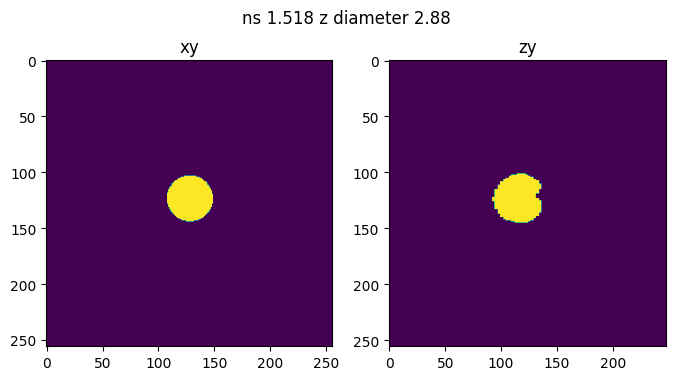

In [102]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.measure import regionprops

bead_thresholded=bead>threshold_otsu(bead)
fig=show_xy_zy_slice(bead_thresholded,128,128,50, sz=z_spacing/xy_spacing, figsize=(8,4))
bead_labeled=label(bead_thresholded)
bead_objects=regionprops(bead_labeled)
o = bead_objects[0]
fig.suptitle("raw bead "+str((o.bbox[3]-o.bbox[0])*z_spacing))

for decon, ns in zip(decons,ns_to_test):
    decon_thresholded=decon>threshold_otsu(decon)

    #fig=show_xy_zy_slice(decon,128,128,50, sz=ratio, figsize=(8,4))
    fig=show_xy_zy_slice(decon_thresholded,128,128,50, sz=z_spacing/xy_spacing, figsize=(8,4))
    decon_labeled=label(decon_thresholded)

    decon_objects=regionprops(decon_labeled)
    o = decon_objects[0]
    fig.suptitle("ns "+str(ns)+' z diameter '+str((o.bbox[3]-o.bbox[0])*z_spacing))


## Now try different numbers of iterations

In [17]:
from clij2fft.richardson_lucy import richardson_lucy

len(psfs)

psfs[5].shape

(255, 255, 255)

get lib
get lib
get lib
get lib
get lib


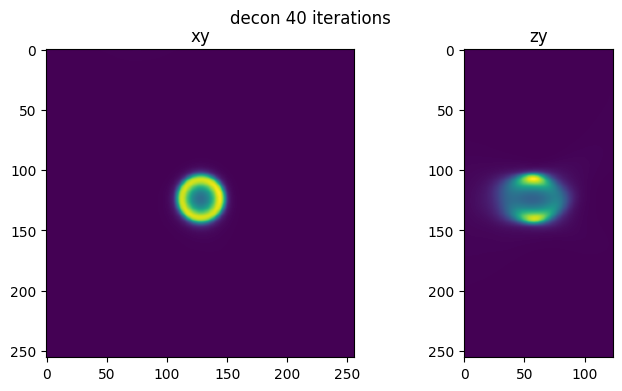

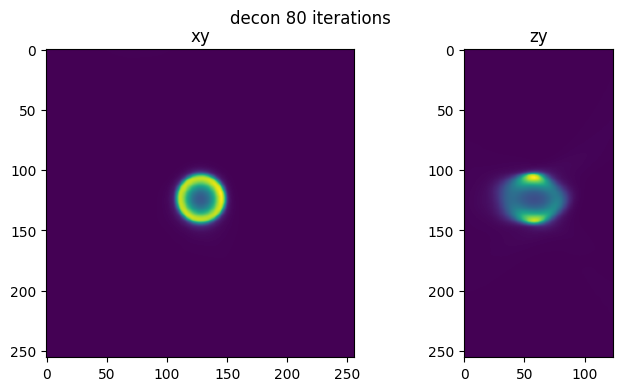

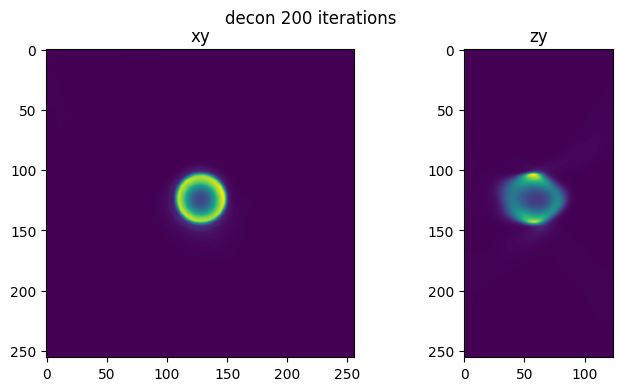

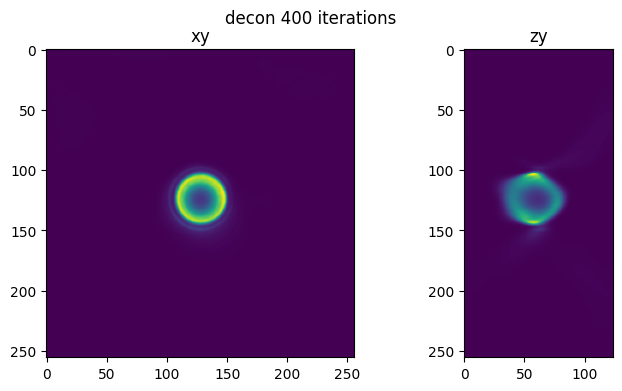

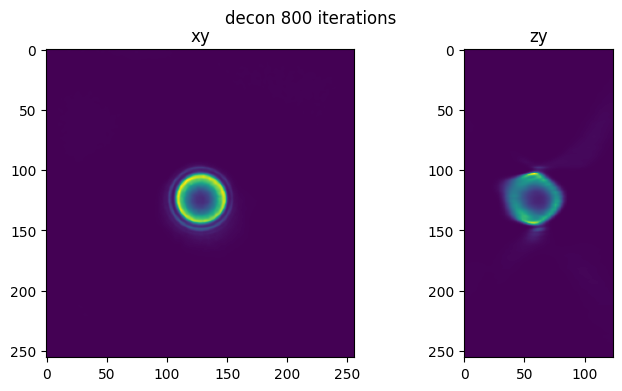

In [19]:

from clij2fft.richardson_lucy import richardson_lucy_nc
regularization_factor=0
decons=[]

path_=r"D:\images\tnia-python-images\deconvolution\bead\iterative"

psf=psfs[3]

iterations=[40,80,200,400,800]
for iteration in iterations:
    im_decon = richardson_lucy_nc(bead, psf, iteration, regularization_factor)
    decons.append(im_decon)
    fig=show_xy_zy_slice(im_decon,128,128,25, sz=ratio, figsize=(8,4))
    fig.suptitle('decon '+str(iteration)+' iterations')
    im_decon=im_decon[::-1,:,:]
    imsave(path_+"/decon-1.48-rlnc"+str(iteration)+".tif", im_decon)

## Theshold and measure axial dimension for different numbers of iterations

In this case the raw bead has an axial diameter over twice as large as the known value.   With 40 iterations it is better, at 80 iterations much better then get's incrementally better up to a few hundred iterations.

Note that the segmenation dimensions are measured in pixels, so we may not be able to detect 'incremental' improbements.  Fitting a curve to the axial intensity profiles and measuring FWHM may be a better way to detect small improvements.  

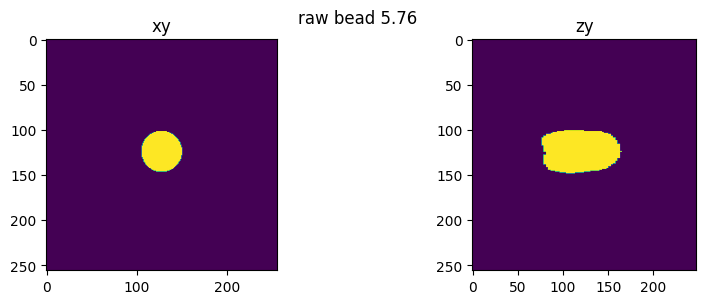

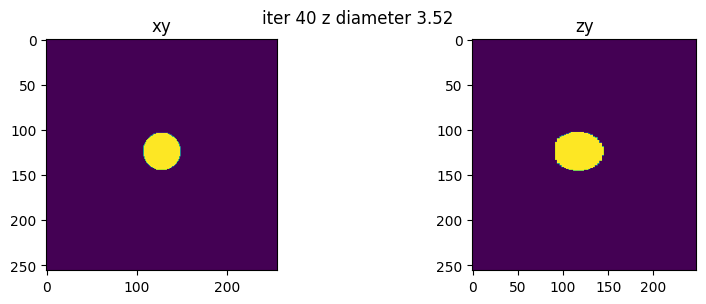

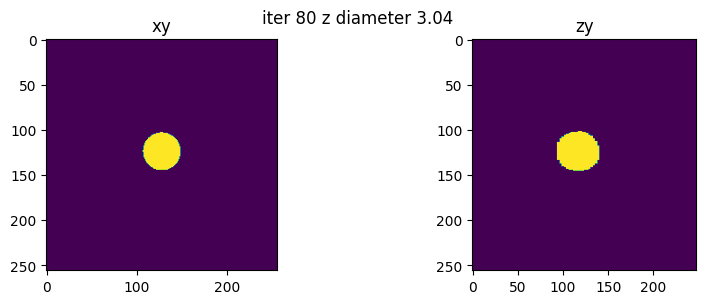

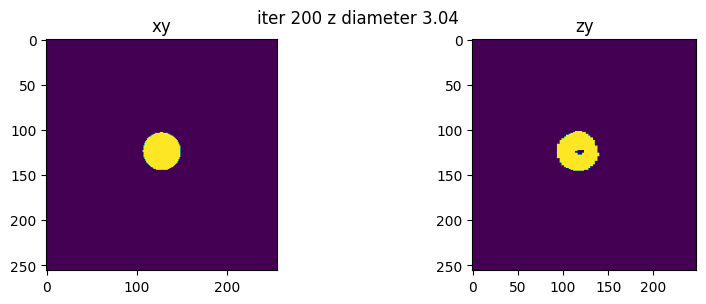

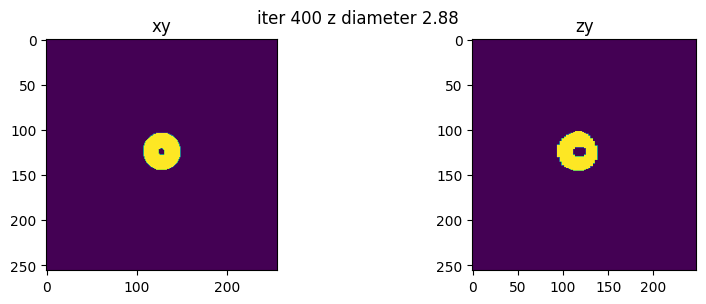

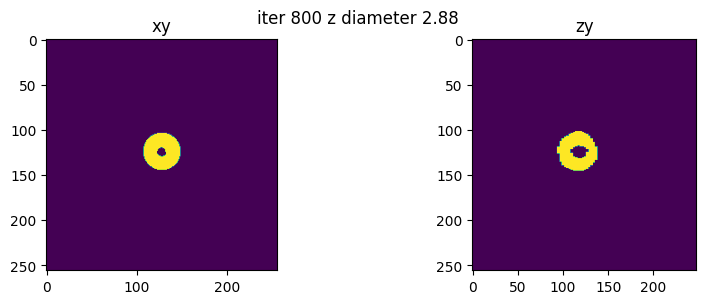

In [97]:

bead_thresholded=bead>threshold_otsu(bead)
fig=show_xy_zy_slice(bead_thresholded,128,128,50, sz=z_spacing/xy_spacing)
bead_labeled=label(bead_thresholded)
bead_objects=regionprops(bead_labeled)
o = bead_objects[0]
fig.suptitle("raw bead "+str((o.bbox[3]-o.bbox[0])*z_spacing))

for decon, iteration in zip(decons,iterations):
    decon_thresholded=decon>threshold_otsu(decon)

    fig=show_xy_zy_slice(decon_thresholded,128,128,50, sz=z_spacing/xy_spacing)
    decon_labeled=label(decon_thresholded)

    decon_objects=regionprops(decon_labeled)
    o = decon_objects[0]
    fig.suptitle("iter "+str(iteration)+' z diameter '+str((o.bbox[3]-o.bbox[0])*z_spacing))


In [2]:
import napari
viewer=napari.Viewer()

#viewer.add_image(bead, scale=(z_spacing/xy_spacing,1,1))
viewer.add_image(decon[0][0], scale=(z_spacing/xy_spacing,1,1))
#viewer.add_image(decons[2], scale=(z_spacing/xy_spacing,1,1))
#viewer.add_image(decons[4], scale=(z_spacing/xy_spacing,1,1))

NameError: name 'decon' is not defined

In [63]:
128*.16

20.48